<a href="https://colab.research.google.com/github/SeungYeon2000/pytorch/blob/main/Chap8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chap8. Using Convolutions to generalize**

from CH7., 특성 일반화 < training set 기억

-> 1. 변수가 너무 많음

1은 cropping images로도 해결 어려워서 **convolution**이 필요!

-> 2. 위치 독립성 X (일반화 어렵)

# 8.1 The case for convolutions

convolutions의 기능 : 위치 deliver, translation invariance(input달라도 output같음.)

멀리 떨어진 pixel보다는 근처 pixel과의 weighted sum을 계산함. = weight 행렬 만들기(결과 특징 하나당, 결과 픽셀 위치당).+중심 픽셀로부터 특정 거리 너머의 모든 weights는 0.

=> " a linear operation"

# 8.1 What convolutions do
training 중에 network가 업데이트 되는 동안 translation invariant위해 픽셀을 같은 값으로 초기화시켜야. & tied weights(언어모델 향상)가 같도록 해야.

=> weights가 이웃 weights와 작동한다 (local 패턴에 반응해서, 위치와 관계없이 local 패턴 인식 가능)

---
결론_*convolution* : 이용가능하고 local하며 translation-invariant한 linear operation이다.





convoluiton (2D image) - scalar * weight 행렬 = kernel

결과 이미지의 요소 계산 가능.(bias 없이)

input image의 위치에서 kernel을 "translate"할 수 있음.

output image는 모든 input 위치에서 kernel을 translate하는 것과 weighted sum을 수행함으로써 만들어진다.

weight는 랜덤으로 초기화되고 역전파에 의해 업데이트됨 + 같은 kernel이 전체 이미지에서 재사용됨.

Convolutions으로 인해
- local operations on neighborhoods
- Translation invariance
- Models with 훨씬 적은 parameters (pixel의 갯수가 아니라 convolution kernel size/얼마나 많은 convolution filters or output channels에 의해)

# 8.2 Convolutions in action
torch.nn module -> 1,2,3 dimensions (nn.Con1d:시간/nn.Con2d:이미지/nn.Con3d:volumes 나 비디오)

CIFAR-10이니까 image(nn.Con2d)로. 여기에 우리가 주는 arguments는 input features나 channels의 갯수, output features의 갯수, 커널 사이즈. 

(output에서 channels가 많을수록 network의 용량도 커진다.)

kernel_size=3은 kernel_size=(3,3) 대신 쓸 수 있는 단축키.

In [ ]:
#In[1]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [ ]:
#In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [ ]:
#In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [ ]:
#In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [ ]:
#In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [ ]:
#In [6]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [ ]:
#In [7]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [ ]:
#In [8]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [ ]:
#In [9]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [ ]:
#In [10]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [ ]:
#In[11]:
conv = nn.Conv2d(3,16,kernel_size=3)    #kernel_size=3 대신 쓸 수 있는 것? -> kernel_size=(3,3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

kernel size가 3*3이니까 weight tensor는 3*3 part로 예상

In [ ]:
#In[12]:
conv.weight.shape, conv.bias.shape    # weights가 전체 이미지에 최적화된 local patterns를 찾는 더 작은 모델을 갖게 됨.

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [ ]:
#In[13]:
img,_ = cifar2[0]
output = conv(img.unsqueeze(0))   #0번째 batch 차원을 더함. (nn.Conv2d는 input tensor 형식이 B*C*H*W라서.)
img.unsqueeze(0).shape, output.shape  

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

<function matplotlib.pyplot.show>

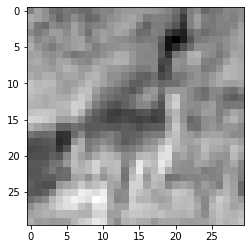

In [ ]:
#In[15]:
plt.imshow(output[0,0].detach(),cmap='gray')
plt.show

# 8.2.1 Padding the boundary
output이 input보다 작다는 사실은 이미지 경계에서 뭘 할지에 관한 부작용.

- convolution kernel as a weighted sum of pixels in a 3*3 neighborhood : 모든 방향에 neighbors가 있어야지만 가능. ex) i00의 경우 왼쪽면에 존재 X
- Pytorch는 width-kernel_width+1을 퉁해 convolution kernel을 slide함. (초기설정)
- 홀수 kernel의 경우 convolution kernel/2 만큼 작은 kernel의 width를 갖게 됨.
*** 그러나 (Zero)PADDING을 하게 될 경우 i00번째 요소라도 추가 set를 가지기 때문에 kernel 유실 없음., 다만 padding을 하더라도 weight나 bias의 크기는 변화 없음!

  [padding하는 이유]

1. convolution과 이미지 사이즈 변화의 문제를 분리시키고 
2. 더욱 정교한 구조를 갖게 된다(ex. skip connections, U-Nets), 몇 번의 컨볼루션 전후에 텐서를 추가하거나 차이를 취할 수 있도록 호환 가능한 크기로.

In [ ]:
#In[16]:
conv=nn.Conv2d(3,1,kernel_size=3,padding=1)
output=conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

#8.2.2 Detecting features with convolutions
1. bias 줄이기 (혼재 줄임).
2. weights를 상수값으로 두어 결과의 각 픽셀이 주변의 평균값을 가지도록.

In [ ]:
#In[17]:
with torch.no_grad():
  conv.bias.zero_()

with torch.no_grad():
  conv.weight.fill_(1.0/9.0)    #weight 설정
# conv.weight.one_()는 주변 픽셀의 합을 나타냄.

<function matplotlib.pyplot.show>

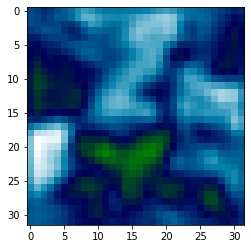

In [ ]:
#In[18]:
output=conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(),cmap='ocean')
plt.show
# 블러 처리된 (좀 더 스무스하게 연관되어 바뀐) 이미지 등장.

# **참고**
underbar(_)가 있는 경우 : in_place (기존 tensor에서. 새로운 tensor 생성되지 않음.)

underbar(_)가 없는 경우 : 새로운 tensor를 만들어냄.

detach() : 기존 Tensor에서 gradient 전파가 안되는 텐서 생성,단 storage를 공유하기에 detach로 생성한 Tensor가 변경되면 원본 Tensor도 똑같이 변함. 

plt.imshow()에 cmap= 인자를 지정하면 이미지에 적용되는 colormap을 변경할 수 있음. 지정하지 않으면 무관한 색상이 등장.

In [ ]:
#In[19]:
conv = nn.Conv2d(3,1,kernel_size=3,padding=1)

with torch.no_grad():
  conv.weight[:] = torch.tensor(
      [[-1.0,0.0,1.0],
       [-1.0,0.0,1.0],
       [-1.0,0.0,1.0]]
  )
  conv.bias.zero_()

kernel이 다른 강도의 두 인접한 지역 사이 수직 경계에 적용되면 o22 = 높은 값.

kernel이 균일한 강도로 적용되면 o22 = 0. 

=>(edge-detection kernel), kernel은 두 수평으로 인접한 지역 사이 수직 구간을 강조함.

convolution kernel은 수직 가장자리를 향상시킨다.

# 8.2.3 Looking further with depth and pooling
CIFAR-10 images는 작지만, objects는 여전히 여러 픽셀들이 교차하고 있다. 이에 따른 해결 방안
1. From large to small : Downsampling : (이미지를 반으로 스케일링하는 것) = (인풋으로 네 개의 이웃 픽셀을 취하고 한 픽셀을 아웃풋으로 두는 것)

1. Downsampling
: 네 개의 픽셀 평균화 "average pooling"

: 네 개의 픽셀 중 가장 큰 값 취하기 "max pooling"
, nn.MaxPool2d module로 제공됨.

: n 번째 픽셀만 계산되는 strided convolution 하기

2. Combining convolutions and downsampling for great good
: 

In [ ]:
#In[21]:
pool = nn.MaxPool2d(2)      # 주어진 image를 반만큼(1/2) downsample한 거니까 2로 써줌.
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

1차 - 첫 번째 커널 세트는 small neighborhoods로 작동, low level features

2차 - 두 번째 커널 세트는 좀 더 넓은 neighborhoods까지

# **8.2.4 Putting it all together for our network**


In [ ]:
#In[22]:
model = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3,padding=1),    #3RGB channels -> 16, 낮은 단계로 구별 가능
    nn.Tanh(),                                  
    nn.MaxPool2d(2),                            # 그 결과 16-channel 32*32 image가 16-channel 16*16 image
    nn.Conv2d(16,8,kernel_size=3,padding=1),    # 그 결과 8-channel 16*16 output (더 높은 레벨의 feature)
    nn.Tanh(),
    nn.MaxPool2d(2)                             # 그 결과 8-channel 8*8 output

)
# 8-channel 8*8 image를 1D 벡터로 바꾸고 fully connected layers로 network를 완성하는 것이 우리의 초기목표.

In [ ]:
#In [23]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... Something is missing : 8-channel 8*8 image -> 512-element로 바꿔줘야 함.(마지막 nn.MaxPool2d 결과에서 view호출함으로써 가능.)
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))
# linear layer의 크기는 MaxPool2d의 예상되는 결과 사이즈에 달려있다. 8*8*8=512.

In [ ]:
#In [24]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list
# 모델의 용량을 늘리려면 convolution layers로 아웃풋 채널 수를 늘려야 한다.

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
#In [25]:
model(img.unsqueeze(0))

RuntimeError: ignored

In [ ]:
#In [26]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out


# 8.3 Subclassing nn.Module
우리만의 nn.Module subclasses를 만들어서 미리 만들어진 것들이나 nn.Sequential처럼 사용할 수 있도록 함.

In [ ]:
#In [27]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
#In [28]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#In [29]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0157,  0.1143]], grad_fn=<AddmmBackward>)

In [ ]:
#In [30]:
import datetime  # python에 포함된 datatime 사용

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # 0에서 시작 아니고 1부터 n_epochs까지
        loss_train = 0.0
        for imgs, labels in train_loader:  # data loader가 만드는 batches에서 우리의 dataset을 loop over 함.
            
            outputs = model(imgs)  # 모델을 통해 batch를 feed
            
            loss = loss_fn(outputs, labels)  # loss계산

            optimizer.zero_grad()  # 이전에서의 gradient제거
            
            loss.backward()  # backward step 수행
            
            optimizer.step()  # 모델 업데이트

            loss_train += loss.item()  # 전체 loss의 합.

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # batch별 평균 loss 얻기 위해 

In [ ]:
#In [31]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # cifar2 dataset의 예시로 batches up함. Shuffle로 dataset으로부터 예시의 차원을 랜덤화함.

model = Net()  #  네트워크 instantiate
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  확률적 경사 하강법 최적화
loss_fn = nn.CrossEntropyLoss()  #  cross entropy loss

training_loop(  # 이전에 정의한 training loop를 호출.
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-07-13 01:53:29.196615 Epoch 1, Training loss 0.56404867939129
2021-07-13 01:53:58.294528 Epoch 10, Training loss 0.32760468742270377
2021-07-13 01:54:30.635679 Epoch 20, Training loss 0.30307469284458527
2021-07-13 01:55:02.997618 Epoch 30, Training loss 0.28098370514477894
2021-07-13 01:55:35.264691 Epoch 40, Training loss 0.26119488620074693
2021-07-13 01:56:07.595348 Epoch 50, Training loss 0.24396828690152259
2021-07-13 01:56:39.823396 Epoch 60, Training loss 0.22478416324800746
2021-07-13 01:57:12.466698 Epoch 70, Training loss 0.2053464343593379
2021-07-13 01:57:44.715682 Epoch 80, Training loss 0.18890236574373429
2021-07-13 01:58:17.041548 Epoch 90, Training loss 0.17473488685431754
2021-07-13 01:58:49.635618 Epoch 100, Training loss 0.1615173067351815


In [ ]:
#In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # gradient 필요하지 않음, update하지 않아도 됨.
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # 아웃풋 값으로 가장 큰 인덱스값 내놓음
                total += labels.shape[0]  # 예시의 숫자 모두 더함, batch size에 의해 total 값 증가.
                correct += int((predicted == labels).sum())  # 예측했던 class(maximum 값)과 ground-truth label비교(Boolean array)

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


- error 수 반으로 줄임(validation set에서)
- 훨씬 적은 parameters 사용

=> locality와 translation invariance를 통해

# 8.4.2 Saving and loading our model


In [ ]:
#In [33]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt') #모델의 모든 파라미터(weights,biases for the two convolution models & two linear models)

In [ ]:
#In [34]:
loaded_model = Net()  # 저장할 때와 불러올 때 Net()정의를 바꾸지 않도록 주의
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))
# 이제 code repository에 미리 훈련된 모델을 포함. 데이터 경로는 'birds_vs_airplanes.pt'

<All keys matched successfully>

# 8.4.3 Training on the GPU
연산을 조금 더 빨리 하기 위해서 GPU에서 연산 수행, tensors(from the data loader) to the GPU, parameters 또한 GPU로 옮길 필요가 있음.

다행히도 nn.Module은 .to함수를 수행한다.

Module.to/Tensor.to.Module.to <-> Tensor.to 다른 개념.

전자는 그 자리에서 tensor를 생성하지만, 후자는 새로운 tensor를 반환한다.
(다른 적절한 디바이스에 파라미터를 옮기고 나서 Optimizer를 생성하는 것은 좋음.)

In [ ]:
#In [35]:
device = (torch.device('cuda') if torch.cuda.is_available()   # device 변수를 torch.cuda.is_available()에 따라 설정.-> :)
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
#In [36]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # imgs와 labels를 우리가 훈련중인 디바이스에 옮기는 것만이 유일한 차이점.
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [ ]:
#In [37]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # 우리의 모델을 GPU로 이동시킴. 빼먹으면 오류 남.(PyTorch는 GPU랑 CPU input mixing 지원 안 함.)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
# validate model에서도 같은 개정이 이루어져야.

2021-07-13 01:59:50.424119 Epoch 1, Training loss 0.5758682179982495
2021-07-13 01:59:53.208614 Epoch 10, Training loss 0.3257187461587274
2021-07-13 01:59:56.280847 Epoch 20, Training loss 0.2901738556517158
2021-07-13 01:59:59.331057 Epoch 30, Training loss 0.2672741515621258
2021-07-13 02:00:02.426408 Epoch 40, Training loss 0.24808442118061577
2021-07-13 02:00:05.488901 Epoch 50, Training loss 0.22970585311484185
2021-07-13 02:00:08.556979 Epoch 60, Training loss 0.2152167026214539
2021-07-13 02:00:11.604453 Epoch 70, Training loss 0.19959015842930528
2021-07-13 02:00:14.670144 Epoch 80, Training loss 0.18537759090400047
2021-07-13 02:00:17.742876 Epoch 90, Training loss 0.16804107401970844
2021-07-13 02:00:20.785587 Epoch 100, Training loss 0.15623469520241592


In [ ]:
#In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)


Accuracy train: 0.92
Accuracy val: 0.89


In [ ]:
#In [39]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device)

SyntaxError: ignored

In [ ]:
#In [40]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#In [41]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

In [ ]:
#In [42]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#In [43]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

In [ ]:
#In [44]:
sum(p.numel() for p in model.parameters())

In [ ]:
#In [45]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # pow(2.0)을 L1 정규화를 위해 abs()로 대체.
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [ ]:
#In [46]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)


In [ ]:
#In [47]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#In [48]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

In [ ]:
#In [49]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#In [50]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)


In [ ]:
#In [51]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#In [52]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)


In [ ]:
#In [53]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#In [54]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

In [ ]:
#In [55]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # BatchNorm layer가 bias의 효과를 취소할수 있어서 남겨짐.
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # 표준편차(ResNet paper에서 계산된)와 함께 일반 무작위 요소로 custom 초기화 사용
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x


In [ ]:
#In [56]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#In [57]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

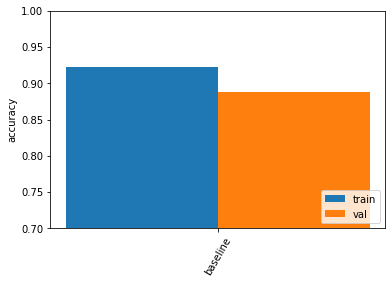

In [ ]:
#In [58]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()